# Training Models for Simulation

The plan is to create machine learning models that can be used to calculate probabilities to use in an agent-based simulation that models the movement of bikes between stations.

Ideas for models: 

1. a model to find the probability that a given bike will be checked out at any point in the day.
2. if a bike is chosen, how long will it be used for and which destination is it going to?

Concerns:

1. Applying the model to bikes at every location might be pretty expensive?
2. Should I precompute the day's bike movements and then present the simulation (potentially longer load time but one call), or should I make API calls during the simulation (lots of API calls but simulation can start right away).
3. How often should I update the values? Every thirty minutes, every hour?
4. Possibility for caching predictions? To be honest, it might be easier to compute all possbilities upfront --> no need for a server
5. How to even determine if a bike is rented at any point in time.

I'm thinking that the best approach will be to compute all possibilties upfront to avoid the prediction actually having to be computed in real time because I don't think there are that many variables. However, I think there should still be some API holding all these values, so they don't have to be loaded on the client side. So the workflow will be:

1. Create models based on bike share data
2. Feed in all combinations to see prediction based on time, station, etc.
3. The simulation will send API calls (number of API calls less of an issue if values are precomputed) which will return probabilities for the current bikes
4. Users can run the simulation for different times of day, nubmers of bikes at each stations (let users save states for the simulations?)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# import data
data = pd.read_csv('./data/metro-bike-share-trip-data.csv')

C:\Users\grant\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
1,1919661,1980,2016-07-07T06:00:00,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."
2,1933383,300,2016-07-07T10:32:00,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
3,1944197,10860,2016-07-07T10:37:00,2016-07-07T13:38:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05..."
4,1940317,420,2016-07-07T12:51:00,2016-07-07T12:58:00,3032.0,34.049889,-118.25588,3032.0,34.049889,-118.25588,6674.0,0.0,Round Trip,Walk-up,"{'longitude': '-118.25588', 'latitude': '34.04...","{'longitude': '-118.25588', 'latitude': '34.04..."


In [4]:
print(data.columns)

Index(['Trip ID', 'Duration', 'Start Time', 'End Time', 'Starting Station ID',
       'Starting Station Latitude', 'Starting Station Longitude',
       'Ending Station ID', 'Ending Station Latitude',
       'Ending Station Longitude', 'Bike ID', 'Plan Duration',
       'Trip Route Category', 'Passholder Type', 'Starting Lat-Long',
       'Ending Lat-Long'],
      dtype='object')


In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132427 entries, 0 to 132426
Data columns (total 16 columns):
Trip ID                       132427 non-null int64
Duration                      132427 non-null int64
Start Time                    132427 non-null object
End Time                      132427 non-null object
Starting Station ID           132408 non-null float64
Starting Station Latitude     132379 non-null float64
Starting Station Longitude    132379 non-null float64
Ending Station ID             132331 non-null float64
Ending Station Latitude       131376 non-null float64
Ending Station Longitude      131376 non-null float64
Bike ID                       132417 non-null float64
Plan Duration                 131661 non-null float64
Trip Route Category           132427 non-null object
Passholder Type               132427 non-null object
Starting Lat-Long             98622 non-null object
Ending Lat-Long               131376 non-null object
dtypes: float64(8), int64(2), object

# Setting Up Machine Learning Environment

In [6]:
import pickle
from sklearn.preprocessing import scale
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
# random forest
from sklearn.ensemble import RandomForestClassifier
# softmax classifier
from sklearn.linear_model import LogisticRegression
# svm
from sklearn.svm import LinearSVC # one-vs-rest classification
# dimensionality reduction
from sklearn.decomposition import FactorAnalysis

Notes:
* for training, I'm simply going to use one cross-validation split because there's a decent amount of data
* because there's so many classes to predict, it may be difficult to actually find the accuracy of the model, especially because the classes are so uneven --> the best I may be able to do is apply some softmax classifier and then use the output for each class as the probability
* I'll choose the best model not based on some number correctly predicted but by aiming for a low cost function

I'm splitting the dataset to find the best model for the lowest cost, but I think for the final model, I'll just train it on all the data because it might give more information to the model about stations that are less frequented.

## Prep Dataset

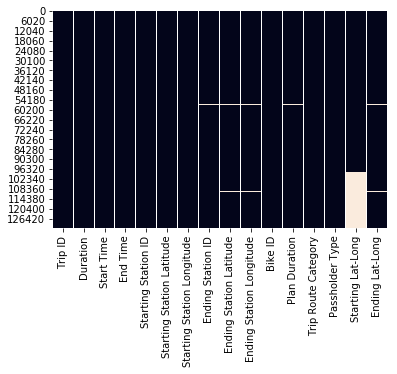

In [7]:
# visualizing null values in dataset
sns.heatmap(data.isnull(), cbar=False)

Wow. I'm impressed that there's hardly any null values. Maybe the dataset was pre-cleaned or something.

In [8]:
# preps the dataframe with scaling and dummy vars
# returns X, y
def prep_df(data, target_var, cat_vars=[], cont_vars=[]):
    df = data.copy()
    total_vars = cont_vars + cat_vars + [target_var]
    model_df = df[total_vars]
    cleaned_df = model_df.dropna(subset=total_vars)
    
    # turns categorical vars into dummy vars
    for var in cat_vars:
        temp_dummy = pd.get_dummies(cleaned_df[var], prefix=var, drop_first=True)
        cleaned_df = pd.concat([cleaned_df.drop([var], axis=1), temp_dummy], axis=1)
    
    # normalize the data
    for var in cont_vars:
        cleaned_df[var] = scale(cleaned_df[var])
    
    return cleaned_df

# Destination of Chosen Bike

Variables for model finding destination of chosen bike:
* Start Time (to the nearest hour?)
* Month of Travel
* Starting Station ID

Target Var:
* End Station ID

Note: not including Passholder Type to make model simpler

In [9]:
type(data['Start Time'][0])

str

So start time is a string, which means some parsing is involved.

In [10]:
data['Start Time'].head(5)

0    2016-07-07T04:17:00
1    2016-07-07T06:00:00
2    2016-07-07T10:32:00
3    2016-07-07T10:37:00
4    2016-07-07T12:51:00
Name: Start Time, dtype: object

Round to the nearest hour. Take the hour and

## Location Model

In [11]:
'''

df: dataframe (after prep_df)
target_var: variable to predict
random_seed: keeps train/test split consistent across models
dim_reduction: configures dimensionality reduction
pickle: whether to pickle the model for further use
training: whether to train on split data


'''
def train_location_model(df, target_var, random_seed=100, dim_reduction={'perform': False, 'n_comps': 2}, pickle_configure={'perform': False, 'filename': 'default.p'}, training=True):
    # precaution against mutating original dataframe
    df = df.copy()
    training_vars = [v for v in df.columns if v != target_var]
    
    # performs dimensionality reduction (FA)
    if dim_reduction['perform']:
        transformer = FactorAnalysis(n_components = dim_reduction['n_comps'], random_state=random_seed)
        X = transformer.fit_transform(df[training_vars])
    else:
        X = df[training_vars]
    
    # splitting into test and training
    if training:
        X_train, X_test, y_train, y_test = train_test_split(X, df[target_var], test_size=0.2, random_state = random_seed)
    else:
        X_train = df[training_vars]
        y_train = df[target_var]
        
    model = LogisticRegression(solver='lbfgs', multi_class='multinomial')
    model.fit(X_train, y_train)
    
    # saves model for later use
    if pickle_configure['perform']:
        pickle.dump(model, open(pickle_configure['filename'], 'wb'))
    
    # if not optimizing model, just return model
    if not training:
        return model
    
    predictions = model.predict_proba(X_test)
    
    # because there are so many target var classes, 
    # use loss to find relative performance
    loss = log_loss(y_test, predictions)
    print(loss)
    
    return model

I chose logistic regression as the training algorithm for its speed and because I'm not particularly concerned with getting the best result, since the results of the model are only going to be used to find rough probabilities for an agent-based simulation.

## Training the Location Model

### First Model (Starting Station and Passholder Type)

In [12]:
data.columns

Index(['Trip ID', 'Duration', 'Start Time', 'End Time', 'Starting Station ID',
       'Starting Station Latitude', 'Starting Station Longitude',
       'Ending Station ID', 'Ending Station Latitude',
       'Ending Station Longitude', 'Bike ID', 'Plan Duration',
       'Trip Route Category', 'Passholder Type', 'Starting Lat-Long',
       'Ending Lat-Long'],
      dtype='object')

In [13]:
location_df = prep_df(data, 'Ending Station ID', cat_vars=['Starting Station ID'], cont_vars=[])

In [14]:
first_model = train_location_model(location_df, target_var='Ending Station ID')

3.5294218153020607


I choose the metric for performance to be log loss because with 63 classes, it doesn't make much sense to gauge based on prediction, especially because the classes are skewed. Also, I don't want a good predictive model, I just want a model that can give me rough probabilities of where the chosen bike will go.

In [15]:
dep_vars = [v for v in location_df if v != 'Ending Station ID']
# finding probability predictions on random entry to check for validity
example = first_model.predict_proba(location_df[17890:17891][dep_vars])
print(example)

[[0.00550108 0.04186708 0.02657345 0.01300753 0.02610084 0.00018179
  0.00092414 0.01390465 0.02735903 0.00346354 0.00876014 0.00420807
  0.00449159 0.00404112 0.05593968 0.00684543 0.00299239 0.01138682
  0.00330254 0.01062271 0.00346839 0.00713191 0.0190509  0.03945292
  0.0257472  0.00228328 0.02378487 0.02065311 0.0075868  0.00503899
  0.04085153 0.00022773 0.00260972 0.01756003 0.00108622 0.00381362
  0.01464222 0.01656254 0.02198847 0.01252643 0.00455434 0.00011147
  0.00475488 0.02458535 0.00537824 0.00190259 0.01112689 0.00553011
  0.00533365 0.00635465 0.02834401 0.02729167 0.00484688 0.00183926
  0.03436241 0.00380783 0.08431207 0.04182031 0.08035331 0.01911776
  0.0121416  0.00217647 0.00082529 0.00087453 0.00414503 0.02527244
  0.00129644]]


In [16]:
example[0].sum()

0.9999999999999998

So it looks like the probabilities at least add up to one, which is a good sign that it correctly represents to probabilities of going to each station.

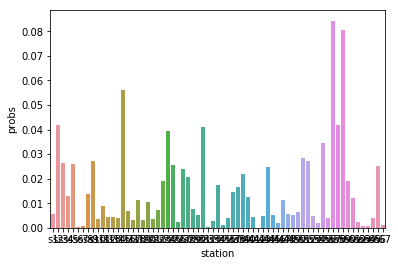

In [17]:
# showing distribution for station probabilities for the example
station_probs = pd.DataFrame()
station_probs['station'] = pd.Series(['s' + str(i + 1) for i in range(len(example[0].tolist()))])
station_probs['probs'] = pd.Series(example[0])
sns.barplot(data=station_probs, x='station', y='probs')

It actually looks like a fair distribution for travel destination. The probabilities don't necessarily overpower each other.

### Second Model (Adding Time Variables)

The previous model only had variables for starting station and passholder type. In this next model, I will add variables for time (time of day and month). Let's see if this model reduces the log loss.

In [18]:
data.head(1)

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.05661,-118.23721,3014.0,34.05661,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05..."


In [19]:
data['Start Time'][0]

'2016-07-07T04:17:00'

In [20]:
# extract month from characters 5:7
# extract hour from -8:-6
# round based on -5:-3
def add_time_var(df):
    df = df.copy()
    hour_data = []
    month_data = []
    
    # calculates time of entry to the nearest hour
    for i, row in df.iterrows():
        hour = int(row['Start Time'][-8:-6])
        minutes = int(row['Start Time'][-5:-3])
        if minutes > 30:
            hour = hour + 1
        if hour == 24: 
            hour = 0
        hour_data.append(hour)
        
        month = row['Start Time'][5:7]
        # converts the month variable into int
        if month[-2] == '0': month = month[-1]
        month_data.append(int(month))
        
    df['Month'] = pd.Series(month_data)
    df['Time_of_Day'] = pd.Series(hour_data)
    return df

In [21]:
location_time_df = add_time_var(data)

In [22]:
location_time_df.head(3)

,Trip ID,Duration,Start Time,End Time,Starting Station ID,Starting Station Latitude,Starting Station Longitude,Ending Station ID,Ending Station Latitude,Ending Station Longitude,Bike ID,Plan Duration,Trip Route Category,Passholder Type,Starting Lat-Long,Ending Lat-Long,Month,Time_of_Day
0,1912818,180,2016-07-07T04:17:00,2016-07-07T04:20:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",7,4
1,1919661,1980,2016-07-07T06:00:00,2016-07-07T06:33:00,3014.0,34.056610,-118.23721,3014.0,34.056610,-118.23721,6281.0,30.0,Round Trip,Monthly Pass,"{'longitude': '-118.23721', 'latitude': '34.05...","{'longitude': '-118.23721', 'latitude': '34.05...",7,6
2,1933383,300,2016-07-07T10:32:00,2016-07-07T10:37:00,3016.0,34.052898,-118.24156,3016.0,34.052898,-118.24156,5861.0,365.0,Round Trip,Flex Pass,"{'longitude': '-118.24156', 'latitude': '34.05...","{'longitude': '-118.24156', 'latitude': '34.05...",7,11


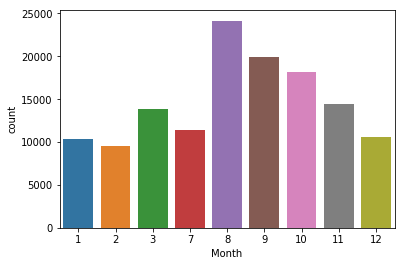

In [23]:
sns.countplot(data=location_time_df, x='Month')

The above trend makes sense. I would expect biking to increase over summer, either because people are more free or because of the warmer weather. But the trend could also be explained by the fact that the bike share program might've been newer during the summer. It seems the data was not collected over an entire year.

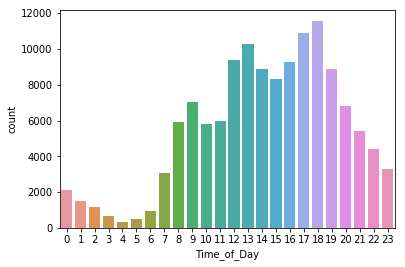

In [24]:
sns.countplot(data=location_time_df, x='Time_of_Day')

In [25]:
model_df_2 = prep_df(location_time_df, 'Ending Station ID', cat_vars=['Starting Station ID', 'Month', 'Time_of_Day'])

In [26]:
second_model = train_location_model(model_df_2, 'Ending Station ID')

3.4301855050223984


The second model does better than the first, but it's difficult to interpret exactly how much better.

### Third Model (Dimensionality Reduction)

In [27]:
# dim_configure_10 = {
#     'perform': True,
#     'n_comps': 10
# }

In [28]:
# third_model_10 = train_location_model(model_df_2, 'Ending Station ID', dim_reduction=dim_configure_10)

In [29]:
# dim_configure_20 = {
#     'perform': True,
#     'n_comps': 20
# }

In [30]:
# third_model_10 = train_location_model(model_df_2, 'Ending Station ID', dim_reduction=dim_configure_20)

In [31]:
# dim_configure_50 = {
#     'perform': True,
#     'n_comps': 50
# }

In [32]:
# third_model_10 = train_location_model(model_df_2, 'Ending Station ID', dim_reduction=dim_configure_50)

I actually don't think at least this form of dimensionality reduction does anything. It also makes training a lot longer because I think it takes away sparsity from the matrix for training.

### Final Model

For the model, I will just use the second one with the time variables, passholder type, and starting station. I haven't even done any hyperparameter tuning or compared training to testing loss, but I think this is good enough to produce the probabilities for the simulation.

In [33]:
pickle_configure = {
    'perform': True,
    'filename': 'location.p'
}

In [34]:
final_model = train_location_model(model_df_2, 'Ending Station ID', training=False, pickle_configure=pickle_configure)

In [35]:
final_model.classes_

array([3000., 3005., 3006., 3007., 3008., 3009., 3010., 3011., 3014.,
       3016., 3018., 3019., 3020., 3021., 3022., 3023., 3024., 3025.,
       3026., 3027., 3028., 3029., 3030., 3031., 3032., 3033., 3034.,
       3035., 3036., 3037., 3038., 3039., 3040., 3042., 3045., 3046.,
       3047., 3048., 3049., 3051., 3052., 3053., 3054., 3055., 3056.,
       3057., 3058., 3059., 3060., 3062., 3063., 3064., 3065., 3066.,
       3067., 3068., 3069., 3074., 3075., 3076., 3077., 3078., 3079.,
       3080., 3081., 3082., 4108.])

The output of probability predictions are in numerical station order.

In [36]:
model_df_2.columns

Index(['Ending Station ID', 'Starting Station ID_3005.0',
       'Starting Station ID_3006.0', 'Starting Station ID_3007.0',
       'Starting Station ID_3008.0', 'Starting Station ID_3009.0',
       'Starting Station ID_3010.0', 'Starting Station ID_3011.0',
       'Starting Station ID_3014.0', 'Starting Station ID_3016.0',
       'Starting Station ID_3018.0', 'Starting Station ID_3019.0',
       'Starting Station ID_3020.0', 'Starting Station ID_3021.0',
       'Starting Station ID_3022.0', 'Starting Station ID_3023.0',
       'Starting Station ID_3024.0', 'Starting Station ID_3025.0',
       'Starting Station ID_3026.0', 'Starting Station ID_3027.0',
       'Starting Station ID_3028.0', 'Starting Station ID_3029.0',
       'Starting Station ID_3030.0', 'Starting Station ID_3031.0',
       'Starting Station ID_3032.0', 'Starting Station ID_3033.0',
       'Starting Station ID_3034.0', 'Starting Station ID_3035.0',
       'Starting Station ID_3036.0', 'Starting Station ID_3037.0',
    